In [275]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.interpolate as interpolate
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline, interp1d
from tqdm import tqdm 
from catmul import *
import math
from skimage.io import imread
from utilities import *
import scipy.ndimage as ndi
import tps_utils as TPS
import random 
from curve_matching import *
from scipy.interpolate import interp1d
import jax
import jax.numpy as jnp

In [397]:
def random_sorted_sample(mylist, sample_size):
    
    
    sorted_sample = [
        mylist[i] for i in sorted(random.sample(range(len(mylist)), sample_size))
    ]
    
    return np.asarray(sorted_sample)

def get_deltas_list(p1_on_path):
    ds1 = []
    for i in range(1, len(p1_on_path)):
        ds = get_delta_s(p1_on_path[i-1] , p1_on_path[i])
        ds1.append(ds)
    return ds1

def get_diffeomorphic_projection(global_path, eps = 1e-4):
    """
    converts discrete matching to a diffeomorphic projection 
    """
    jitter_x , jitter_y = [0], [0]
    for i  in  range(1, len(global_path)):
        g1, g2 = global_path[i]

        if g1 == global_path[i-1][0]:
            jitter_x.append(jitter_x[-1]+eps ) 
        else:
            jitter_x.append(0)

        if g2 == global_path[i-1][1]:
            jitter_y.append( jitter_y[-1]+eps )
        else:
            jitter_y.append(0)


    jitter = np.asarray([jitter_x, jitter_y]).T
    return global_path+jitter, jitter 


## create test data and interpolation 

In [65]:
"""p1 = np.asarray(pickle.load(open("/Users/ranjak/Downloads/jaxreg/all_pts.pkl", "rb"))).T[1:,:]
p2 = np.asarray(pickle.load(open("/Users/ranjak/Downloads/jaxreg/ref_pts.pkl", "rb"))).T[1:,:]"""

p1 = pickle.load(open("/Users/ranjak/thesis/ref_pts.pkl", "rb")).T[3:]
p2 = pickle.load(open("/Users/ranjak/thesis/dapi_pts.pkl", "rb")).T[3:]

In [66]:
fix = imread("/Users/ranjak/Downloads/jaxreg/syn/fix1.png")
mov = imread("/Users/ranjak/Downloads/jaxreg/syn/mov1.png")

In [67]:
p1_x, p1_y = p1[:, 0], p1[:, 1]
p2_x, p2_y = p2[:, 0], p2[:, 1]


In [68]:
xmin = min(min(p1_x), min(p2_x))
xmax = max(max(p1_x), max(p2_x))

In [69]:
#Define alpha
a=0.
npts = 10
# Calculate the Catmull-Rom splines through the points
c1 = CatmullRomChain(p1,a, npts)
c2 = CatmullRomChain(p2,a, npts)

p1_int = np.asarray([(x1, y1) for x1, y1 in c1])
p2_int = np.asarray([(x1, y1) for x1, y1 in c2])

In [70]:
p1_int = random_sorted_sample(list(p1_int), 100)
p2_int = random_sorted_sample(list(p2_int), 150)

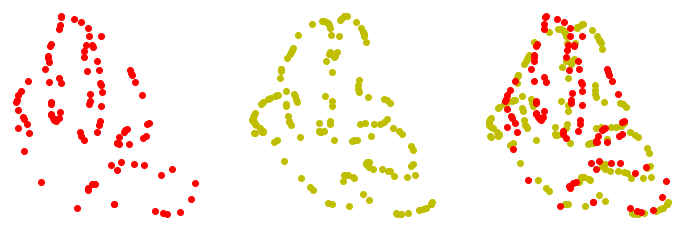

In [71]:
plot_points(p1_int, p2_int)

In [72]:
p1_int, p2_int =  get_unique_elements(p1_int), get_unique_elements(p2_int)

## solve dp for curve matching 

In [73]:
#plot_cost_map(50, 50, p1_int, p2_int)

In [74]:
kappa1, _ = get_kappa_and_derivatives(p1_int)
kappa2, _ = get_kappa_and_derivatives(p2_int)

In [75]:
dsi_list = get_segments_from_pt_list(p1_int)
frac = 2.
R = frac*np.mean(dsi_list)

In [76]:

dist = np.zeros((len(p1_int), len(p2_int)))
for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):
        dist[i][j] = np.inf
dist[0][0] = 0.0

predecessor =[[(-1, -1) for i in range(dist.shape[1])] for j in range(dist.shape[0])]
for i in tqdm(range(1,dist.shape[0])):
    
    for j in range(1, dist.shape[1]):
        
        options = []
        str_tup_list, end_tup_list = get_tup_list(i, j)
        for (str_tup, end_tup) in zip(str_tup_list, end_tup_list):
            i1, i2 = str_tup
            j1, j2 = end_tup
            cost = matching_cost(i1, i2, j1, j2, p1_int, p2_int, kappa1, kappa2, R)
            options.append(dist[i1][j1] + cost)
            
        trace_index = np.argmin(options)        
        (st1, st2), (et1, et2) = str_tup_list[trace_index], end_tup_list[trace_index]
        predecessor[st2][et2] = (st1, et1)        
        dist [i][j] = min(options)



100%|██████████| 97/97 [00:14<00:00,  6.58it/s]


In [77]:
dist

array([[   0.        ,           inf,           inf, ...,           inf,
                  inf,           inf],
       [          inf,    9.53133758,    8.23303927, ..., 1277.55165845,
        1295.85335809, 1314.54897723],
       [          inf,   25.28565266,   29.66032039, ..., 1238.39152959,
        1256.69322924, 1275.38884837],
       ...,
       [          inf, 1056.6163349 ,  967.12128371, ...,  361.17052915,
         360.68653115,  379.38215029],
       [          inf, 1088.61389699,  999.1188458 , ...,  339.96508245,
         358.26678209,  374.99655536],
       [          inf, 1109.69226687, 1020.19721568, ...,  319.20335075,
         337.50505039,  356.20066953]])

In [198]:
global_path = np.asarray(get_matches(dist, predecessor))
global_path = global_path[::-1]

In [199]:
len(p1_int), len(p2_int)

(98, 146)

In [202]:

p1_on_path = p1_int[global_path[:, 0]]
p2_on_path = p2_int[global_path[:, 1]]
ds1 = get_deltas_list(p1_on_path)
ds2 = get_deltas_list(p2_on_path)

In [204]:
## plot the diffeomorphic projection of the discrete solution 
global_path   = np.asarray(global_path)
tot_len = np.asarray([len(p1_int)-1, len(p2_int)-1])
global_path = global_path / tot_len
global_path = global_path[::-1]



In [208]:
global_path1 , jitter = get_diffeomorphic_projection(global_path)

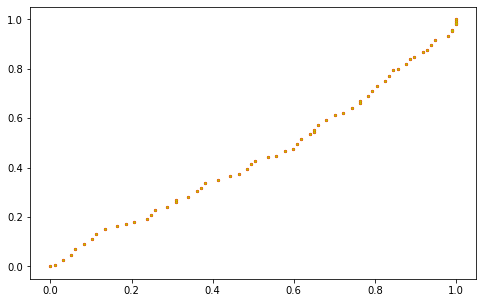

In [209]:
plt.figure(figsize = (8,5))
plt.scatter(global_path[:, 0], global_path[:, 1], c = "r", s = 5)
plt.scatter(global_path1[:, 0], global_path1[:, 1], c = "y", s = 2.5)

In [404]:
xx, yy = global_path[:, 0], global_path[:, 1]
kappa1 , _ = get_kappa_and_derivatives(p1_int)
kappa2 , _ = get_kappa_and_derivatives(p2_int)


In [453]:
## compute energy of the smoothed curve 
def get_params_for_energy(global_path1, sigma):
    
    global_path1 = scipy.ndimage.gaussian_filter(global_path1, sigma )
    zeta1 , zeta2 = global_path1[:, 0], global_path1[:, 1]
    dzeta1 , dzeta2 = np.gradient(zeta1), np.gradient(zeta2) ## dx/dt and dy/dt
    dzeta_hyp = np.sqrt(dzeta1**2 + dzeta2**2)
    cos_psi = dzeta1/dzeta_hyp
    sin_psi = dzeta2/dzeta_hyp
    return zeta1, zeta2, cos_psi, sin_psi


def compute_energy(zeta1, zeta2, kappa1, kappa2, cos_psi, sin_psi):
    tc = 0
    for i, (z1, z2) in enumerate(zip(zeta1, zeta2)):
        dzeta = np.sqrt(z1**2 + z2**2)
        ct = dzeta*(abs(cos_psi[i] - sin_psi[i]) + R*abs(kappa1[i]*cos_psi[i] - kappa2[i]*sin_psi[i]))
        tc = tc + ct
    return tc, zeta1, zeta2
    

In [457]:
sigmas = np.linspace(.001, 100, 10000)
sigmas

array([1.00000000e-03, 1.10009001e-02, 2.10018002e-02, ...,
       9.99799982e+01, 9.99899991e+01, 1.00000000e+02])

In [460]:
energies = []
for sig in tqdm(sigmas):
    zeta1, zeta2, cos_psi, sin_psi = get_params_for_energy(global_path1, sig)
    e, _1, _2 = compute_energy(zeta1, zeta2, kappa1, kappa2, cos_psi, sin_psi)
    energies.append(e)

100%|██████████| 10000/10000 [00:04<00:00, 2092.04it/s]


8.121730873087309


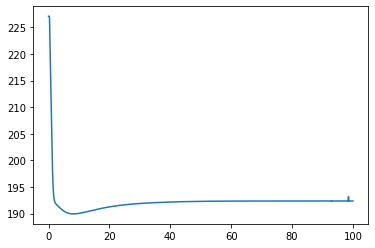

In [461]:
plt.plot(sigmas, energies)
sigmin = sigmas[np.argmin(energies)]
print(sigmin)

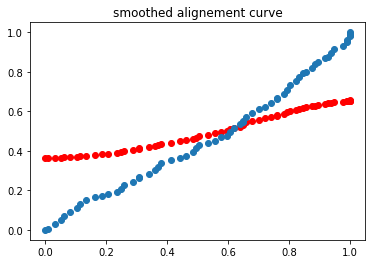

In [475]:
plt.title("smoothed alignement curve")
plt.scatter(xx, yys, c = "r")
plt.scatter(xx, yy)

In [469]:
smm = scipy.ndimage.gaussian_filter(global_path1, 8.12)

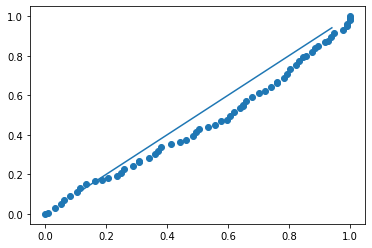

In [470]:
plt.plot(smm[:, 0], smm[:, 1])
plt.scatter(xx, yy)

In [471]:
smm = smm*tot_len

In [472]:
smm


array([[ 91.32978795, 136.52385693],
       [ 91.19932968, 136.32884141],
       [ 90.93994203, 135.94109582],
       [ 90.55463777, 135.36512385],
       [ 90.0478016 , 134.60747992],
       [ 89.42498189, 133.67645804],
       [ 88.69279218, 132.58194449],
       [ 87.85863817, 131.33500969],
       [ 86.93050003, 129.94758278],
       [ 85.91669851, 128.43210208],
       [ 84.82566611, 126.8011729 ],
       [ 83.66578957, 125.06733219],
       [ 82.44516854, 123.24268771],
       [ 81.17155322, 121.33882485],
       [ 79.85216989, 119.36654586],
       [ 78.4936765 , 117.33580337],
       [ 77.10217092, 115.2557128 ],
       [ 75.68305334, 113.13434667],
       [ 74.24111435, 110.97886619],
       [ 72.78050795, 108.79548099],
       [ 71.30481193, 106.58953938],
       [ 69.81700115, 104.36548834],
       [ 68.31950225, 102.12695538],
       [ 66.81424957,  99.87683206],
       [ 65.3026431 ,  97.61721121],
       [ 63.78565624,  95.34954794],
       [ 62.26384802,  93.07467793],
 

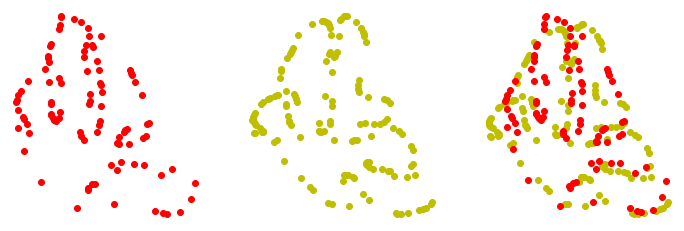

In [82]:
plot_points(p1_int, p2_int)

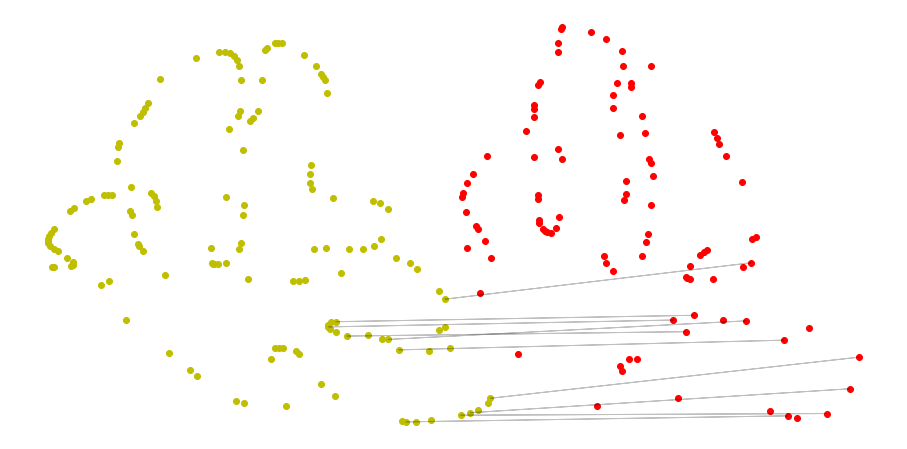

In [83]:
plot_matches(p1_int, p2_int, global_path, 80, 10, 10)

In [234]:
len(global_path), len(p1_int), len(p2_int)

(277, 469, 469)

In [265]:
import importlib
importlib.reload(TPS)

<module 'tps_utils' from '/Users/ranjak/Downloads/jaxreg/tps_utils.py'>

In [271]:
n_sample = 100

global_path = np.asarray(global_path)
p1_index = global_path[:, 0]
p2_index = global_path[:, 1]
p1_pts = p1_int[p1_index]
p2_pts = p2_int[p2_index]

c =list(zip(p1_pts, p2_pts))
cPt = random.sample(c, n_sample)
p1_pts, p2_pts = zip(*cPt)
p1_pts = np.asarray(p1_pts)
p2_pts = np.asarray(p2_pts)
"""plt.scatter(p1_pts[:, 0], p1_pts[:, 1], c ="r")
plt.scatter(p2_pts[:, 0], p2_pts[:, 1], c ="y")"""

'plt.scatter(p1_pts[:, 0], p1_pts[:, 1], c ="r")\nplt.scatter(p2_pts[:, 0], p2_pts[:, 1], c ="y")'

In [272]:
coordinates = TPS.Coordinates([0, 120, 0, 120])
tps = TPS.ThinPlateSpline(coordinates, p1_pts, p2_pts, fix, mov)

In [273]:
params1 = tps.fit(lmatrix = False)
warpf = tps.warp(params1)

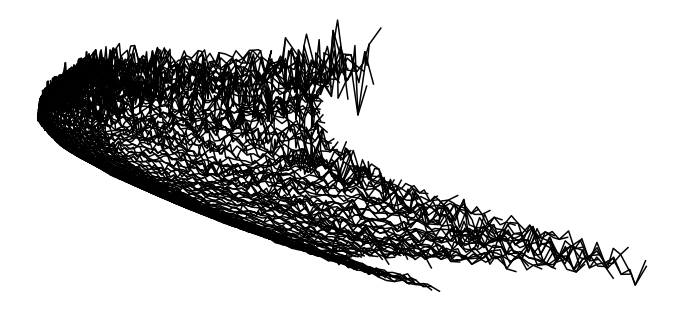

In [274]:
show_warp_field(warpf, plot_separately = False, interval = 2, size = (12, 6))

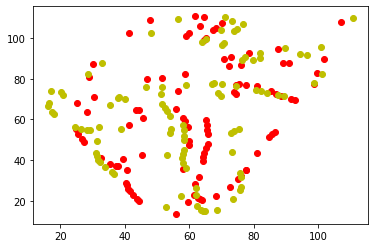

In [276]:
plt.scatter(p1_pts[:, 0], p1_pts[:, 1], c ="r")
plt.scatter(p2_pts[:, 0], p2_pts[:, 1], c ="y")

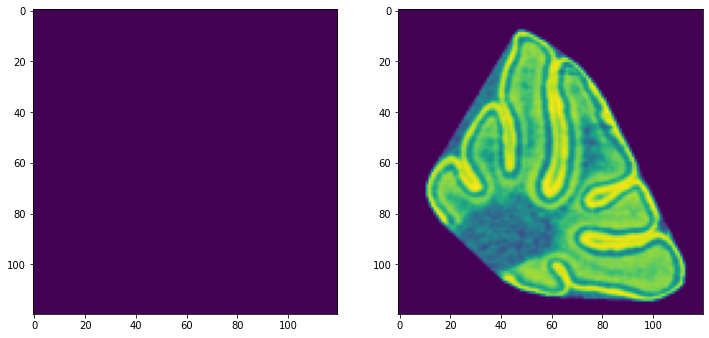

In [275]:
mv = ndi.map_coordinates(mov, warpf, order = 1)
f, a = plt.subplots(1 , 2, figsize = (12, 6) )
a[0].imshow(mv.T)
a[1].imshow(fix)
plt.show()